Epoch 1, Average loss: 165.5122
Epoch 2, Average loss: 121.4267
Epoch 3, Average loss: 114.5898
Epoch 4, Average loss: 111.7133
Epoch 5, Average loss: 109.9018
Epoch 6, Average loss: 108.7757
Epoch 7, Average loss: 107.8544
Epoch 8, Average loss: 107.2559
Epoch 9, Average loss: 106.6941
Epoch 10, Average loss: 106.3364


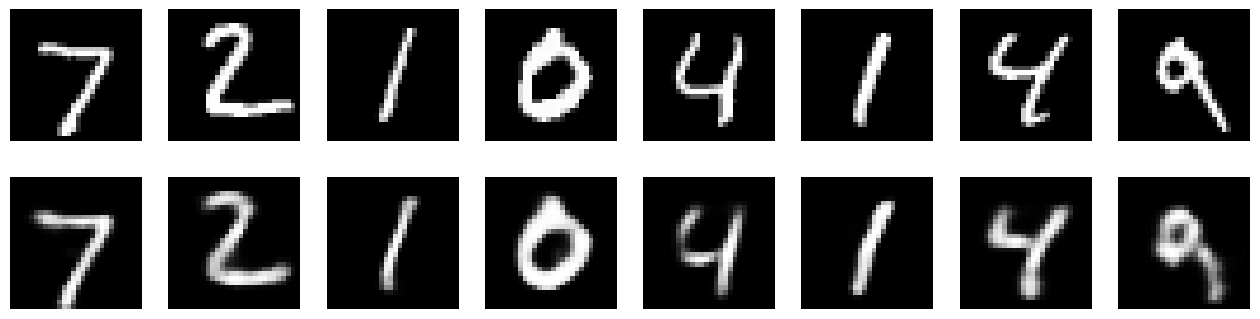

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# -------------------------
# 1. 資料準備
# -------------------------
batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # 28x28 -> 784 向量
])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# -------------------------
# 2. 模型設計
# -------------------------
latent_dim = 20  # 潛在空間維度

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(784, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

        # Decoder
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))  # Sigmoid -> [0,1] 範圍

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# -------------------------
# 3. 訓練設定
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# VAE Loss = 重建誤差 + KL散度
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# -------------------------
# 4. 訓練過程
# -------------------------
epochs = 10

for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        recon_x, mu, logvar = model(x)
        loss = loss_function(recon_x, x, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}, Average loss: {avg_loss:.4f}")

# -------------------------
# 5. 測試與輸出結果
# -------------------------
model.eval()
with torch.no_grad():
    test_batch, _ = next(iter(test_loader))
    test_batch = test_batch.to(device)
    recon_batch, _, _ = model(test_batch)

    # 畫出前 8 張原始 & 重建圖片
    n = 8
    plt.figure(figsize=(16, 4))
    for i in range(n):
        # 原圖
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(test_batch[i].cpu().view(28, 28), cmap="gray")
        plt.axis("off")

        # 重建圖
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(recon_batch[i].cpu().view(28, 28), cmap="gray")
        plt.axis("off")

    plt.savefig("vae_mnist_reconstruction.png")
    plt.show()
